In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from time_res_util import get_compiled_NF_model
import torch
from momentum_prediction_util import load_defaultdict, get_key
from tqdm import tqdm
import time
from itertools import groupby
from GNN_util import process_df_vectorized,create_directory,HitDataset,create_fast_edge_lists,visualize_detector_graph,GIN,train_GNN,test_GNN,calculate_bin_rmse
from dgl.data import DGLDataset
import dgl

In [104]:
class SiPMSignalProcessorNEW:
    def __init__(self, 
                 sampling_rate=40e9,  # 40 GHz sampling rate
                 tau_rise=1.1e-9,       # 1 ns rise time
                 tau_fall=15e-9,      # 50 ns fall time
                 window=200e-9,       # 200 ns time window
#                  cfd_delay=5e-9,      # 5 ns delay for CFD
                 cfd_fraction=0.3):   # 30% fraction for CFD
        
        self.sampling_rate = sampling_rate
        self.tau_rise = tau_rise
        self.tau_fall = tau_fall
        self.window = window
#         self.cfd_delay = cfd_delay
        self.cfd_fraction = cfd_fraction
        self.cfd_delay = self.tau_rise * (1 - self.cfd_fraction)
        
        # Time array for single pulse shape
        self.time = np.arange(0, self.window, 1/self.sampling_rate)
        
        # Generate single pulse shape
        self.pulse_shape = self._generate_pulse_shape()
    
    def _generate_pulse_shape(self):
        """Generate normalized pulse shape for a single photon"""
        shape = np.exp(-self.time/self.tau_fall) - np.exp(-self.time/self.tau_rise)
        return shape / np.max(shape)  # Normalize
    
    def generate_waveform(self, photon_times):
        """Generate waveform from list of photon arrival times"""
        # Initialize waveform array
        waveform = np.zeros_like(self.time)
        
        # Add pulse for each photon
        for t in photon_times:
            if 0 <= t < self.window:
                idx = int(t * self.sampling_rate)
                remaining_samples = len(self.time) - idx
                waveform[idx:] += self.pulse_shape[:remaining_samples]
        
        return self.time, waveform
    
    def integrate_charge(self, waveform, integration_start=0, integration_time=100e-9):
        """Integrate charge in specified time window"""
        start_idx = int(integration_start * self.sampling_rate)
        end_idx = int((integration_start + integration_time) * self.sampling_rate)
        
        # Integrate using trapezoidal rule
        charge = np.trapezoid(waveform[start_idx:end_idx], dx=1/self.sampling_rate)
        return charge
    def constant_threshold_timing(self,waveform,threshold):
        for i in range(len(self.time)):
            if(waveform[i] > threshold):
                return self.time[i]
        return None
        
    def apply_cfd(self, waveform, use_interpolation=True):
        """Apply Constant Fraction Discrimination to the waveform.

        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to process
        use_interpolation : bool, optional
            If True, use linear interpolation for sub-sample precision
            If False, return the sample index of zero crossing
            Default is True

        Returns:
        --------
        tuple (numpy.ndarray, float)
            CFD processed waveform and the zero-crossing time in seconds.
            If use_interpolation is False, zero-crossing time will be aligned
            to sample boundaries.
        """
        # Calculate delay in samples
        delay_samples = int(self.cfd_delay * self.sampling_rate)

        # Create delayed and attenuated versions of the waveform
        delayed_waveform = np.pad(waveform, (delay_samples, 0))[:-delay_samples]
        attenuated_waveform = -self.cfd_fraction * waveform

        # Calculate CFD waveform
        cfd_waveform = delayed_waveform + attenuated_waveform

        # Find all zero crossings
        zero_crossings = np.where(np.diff(np.signbit(cfd_waveform)))[0]

        if len(zero_crossings) < 2:  # Need at least two crossings for valid CFD
            return cfd_waveform, None

        # Find the rising edge of the original pulse
        pulse_start = np.where(waveform > np.max(waveform) * self.cfd_fraction)[0]  # cfd fraction threshold
        if len(pulse_start) == 0:
            return cfd_waveform, None
        pulse_start = pulse_start[0]

        # Find the first zero crossing that occurs after the pulse starts
        valid_crossings = zero_crossings[zero_crossings > pulse_start]
        if len(valid_crossings) == 0:
            return cfd_waveform, None

        crossing_idx = valid_crossings[0]

        if not use_interpolation:
            # Simply return the sample index converted to time
            crossing_time = crossing_idx / self.sampling_rate
        else:
            # Use linear interpolation for sub-sample precision
            y1 = cfd_waveform[crossing_idx]
            y2 = cfd_waveform[crossing_idx + 1]

            # Calculate fractional position of zero crossing
            fraction = -y1 / (y2 - y1)

            # Calculate precise crossing time
            crossing_time = (crossing_idx + fraction) / self.sampling_rate

        return cfd_waveform, crossing_time


    def get_pulse_timing(self, waveform, threshold=0.1):
        """Get pulse timing using CFD method with additional validation.
        
        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to analyze
        threshold : float
            Minimum amplitude threshold for valid pulses (relative to max amplitude)
            
        Returns:
        --------
        float or None
            Timestamp of the pulse in seconds, or None if no valid pulse found
        """
        # Check if pulse amplitude exceeds threshold
        max_amplitude = np.max(waveform)
        if max_amplitude < threshold:
            return None
            
        # Apply CFD
        _, crossing_time = self.apply_cfd(waveform)
        
        return crossing_time, _

In [116]:
class SiPMSignalProcessor:
    def __init__(self, 
                 sampling_rate=40e9,  # 40 GHz sampling rate
                 tau_rise=1.1e-9,       # 1 ns rise time
                 tau_fall=15e-9,      # 50 ns fall time
                 window=200e-9,       # 200 ns time window
                 cfd_delay=5e-9,      # 5 ns delay for CFD
                 cfd_fraction=0.3):   # 30% fraction for CFD
        
        self.sampling_rate = sampling_rate
        self.tau_rise = tau_rise
        self.tau_fall = tau_fall
        self.window = window
        self.cfd_delay = cfd_delay
        self.cfd_fraction = cfd_fraction
#         self.cfd_delay = self.tau_rise * (1 - self.cfd_fraction)
        
        # Time array for single pulse shape
        self.time = np.arange(0, self.window, 1/self.sampling_rate)
        
        # Generate single pulse shape
        self.pulse_shape = self._generate_pulse_shape()
    
    def _generate_pulse_shape(self):
        """Generate normalized pulse shape for a single photon"""
        shape = np.exp(-self.time/self.tau_fall) - np.exp(-self.time/self.tau_rise)
        return shape / np.max(shape)  # Normalize
    
    def generate_waveform(self, photon_times):
        """Generate waveform from list of photon arrival times"""
        # Initialize waveform array
        waveform = np.zeros_like(self.time)
        
        # Add pulse for each photon
        for t in photon_times:
            if 0 <= t < self.window:
                idx = int(t * self.sampling_rate)
                remaining_samples = len(self.time) - idx
                waveform[idx:] += self.pulse_shape[:remaining_samples]
        
        return self.time, waveform
    
    def integrate_charge(self, waveform, integration_start=0, integration_time=100e-9):
        """Integrate charge in specified time window"""
        start_idx = int(integration_start * self.sampling_rate)
        end_idx = int((integration_start + integration_time) * self.sampling_rate)
        
        # Integrate using trapezoidal rule
        charge = np.trapezoid(waveform[start_idx:end_idx], dx=1/self.sampling_rate)
        return charge
    def constant_threshold_timing(self,waveform,threshold):
        for i in range(len(self.time)):
            if(waveform[i] > threshold):
                return self.time[i]
        return None
        
    def apply_cfd(self, waveform, use_interpolation=True):
        """Apply Constant Fraction Discrimination to the waveform.

        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to process
        use_interpolation : bool, optional
            If True, use linear interpolation for sub-sample precision
            If False, return the sample index of zero crossing
            Default is True

        Returns:
        --------
        tuple (numpy.ndarray, float)
            CFD processed waveform and the zero-crossing time in seconds.
            If use_interpolation is False, zero-crossing time will be aligned
            to sample boundaries.
        """
        # Calculate delay in samples
        delay_samples = int(self.cfd_delay * self.sampling_rate)

        # Create delayed and attenuated versions of the waveform
        delayed_waveform = np.pad(waveform, (delay_samples, 0))[:-delay_samples]
        attenuated_waveform = -self.cfd_fraction * waveform

        # Calculate CFD waveform
        cfd_waveform = delayed_waveform + attenuated_waveform

        # Find all zero crossings
        zero_crossings = np.where(np.diff(np.signbit(cfd_waveform)))[0]

        if len(zero_crossings) < 2:  # Need at least two crossings for valid CFD
            return cfd_waveform, None

        # Find the rising edge of the original pulse
        pulse_start = np.where(waveform > np.max(waveform) * 0.1)[0]  # cfd fraction threshold
        if len(pulse_start) == 0:
            return cfd_waveform, None
        pulse_start = pulse_start[0]

        # Find the first zero crossing that occurs after the pulse starts
        valid_crossings = zero_crossings[zero_crossings > pulse_start]
        if len(valid_crossings) == 0:
            return cfd_waveform, None

        crossing_idx = valid_crossings[0]

        if not use_interpolation:
            # Simply return the sample index converted to time
            crossing_time = crossing_idx / self.sampling_rate
        else:
            # Use linear interpolation for sub-sample precision
            y1 = cfd_waveform[crossing_idx]
            y2 = cfd_waveform[crossing_idx + 1]

            # Calculate fractional position of zero crossing
            fraction = -y1 / (y2 - y1)

            # Calculate precise crossing time
            crossing_time = (crossing_idx + fraction) / self.sampling_rate

        return cfd_waveform, crossing_time


    def get_pulse_timing(self, waveform, threshold=0.1):
        """Get pulse timing using CFD method with additional validation.
        
        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to analyze
        threshold : float
            Minimum amplitude threshold for valid pulses (relative to max amplitude)
            
        Returns:
        --------
        float or None
            Timestamp of the pulse in seconds, or None if no valid pulse found
        """
        # Check if pulse amplitude exceeds threshold
        max_amplitude = np.max(waveform)
        if max_amplitude < threshold:
            print("Failed to pass threshold")
            return None
            
        # Apply CFD
        cfd_waveform, crossing_time = self.apply_cfd(waveform)
        
        return crossing_time, cfd_waveform

In [121]:
new_p = SiPMSignalProcessor()
a, b = new_p.get_pulse_timing(waveform)

In [118]:

processer = SiPMSignalProcessor()

In [106]:
normalizing_flow = model_compile
batch_size=50000
device='cuda'
pixel_threshold = 5
useCFD = True
all_context = []
all_time_pixels = []
all_metadata = []
num_pixel_list = ["num_pixels_high_z","num_pixels_low_z"]
print("Processing data in new_prepare_nn_input...")
for event_idx, event_data in tqdm(processed_data.items()):
    for stave_idx, stave_data in event_data.items():
        for layer_idx, layer_data in stave_data.items():
            for segment_idx, segment_data in layer_data.items():
                trueID_list = []
                for particle_id, particle_data in segment_data.items():
                    # Need z, theta, p for sampling from NF
                    base_context = torch.tensor([particle_data['z_pos'], particle_data['hittheta'], particle_data['hitmomentum']], 
                                                dtype=torch.float32)
                    # Need time of track hit to get absolute time of photon hit
                    base_time_pixels_low = torch.tensor([particle_data['time'], particle_data['num_pixels_low_z']], 
                                                    dtype=torch.float32)
                    base_time_pixels_high = torch.tensor([particle_data['time'], particle_data['num_pixels_high_z']], 
                                                    dtype=torch.float32)
                    if particle_data['trueID'] not in  trueID_list:
                        trueID_list.append(particle_data['trueID'])
                    for SiPM_idx in range(2):
                        z_pos = particle_data['z_pos']
                        context = base_context.clone()
                        context[0] = z_pos
                        num_pixel_tag = num_pixel_list[SiPM_idx]
                        all_context.append(context.repeat(particle_data[num_pixel_tag], 1))
                        if(SiPM_idx == 0):
                            all_time_pixels.append(base_time_pixels_high.repeat(particle_data[num_pixel_tag], 1))
                        else:
                            all_time_pixels.append(base_time_pixels_low.repeat(particle_data[num_pixel_tag], 1))
                        # Assuming particle_data is a dictionary-like object and trueID_list is defined
                        fields = [
                            'truemomentum', 'trueID', 'truePID', 'hitID', 'hitPID', 
                            'truetheta', 'truephi', 'strip_x', 'strip_y', 'strip_z', 
                            'hit_x', 'hit_y', 'hit_z', 'KMU_trueID', 'KMU_truePID', 
                            'KMU_true_phi', 'KMU_true_momentum_mag', 'KMU_endpoint_x', 
                            'KMU_endpoint_y', 'KMU_endpoint_z'
                        ]

                        all_metadata.extend([(event_idx,stave_idx, layer_idx,segment_idx, SiPM_idx, particle_data['truemomentum'],particle_data['trueID'],particle_data['truePID'],particle_data['hitID'],particle_data['hitPID'],particle_data['truetheta'],particle_data['truephi'],particle_data['strip_x'],particle_data['strip_y'],particle_data['strip_z'],len(trueID_list),particle_data['hit_x'],particle_data['hit_y'],particle_data['hit_z'],particle_data['KMU_trueID'],particle_data['KMU_truePID'],particle_data['KMU_true_phi'],particle_data['KMU_true_momentum_mag'],particle_data['KMU_endpoint_x'],particle_data['KMU_endpoint_y'],particle_data['KMU_endpoint_z'])] * particle_data[num_pixel_tag])

all_context = torch.cat(all_context)
all_time_pixels = torch.cat(all_time_pixels)

print("Sampling data...")
sampled_data = []
begin = time.time()
for i in tqdm(range(0, len(all_context), batch_size)):
    batch_end = min(i + batch_size, len(all_context))
    batch_context = all_context[i:batch_end].to(device)
    batch_time_pixels = all_time_pixels[i:batch_end]

    with torch.no_grad():
        samples = abs(normalizing_flow.sample(num_samples=len(batch_context), context=batch_context)[0]).squeeze(1)

    sampled_data.extend(samples.cpu() + batch_time_pixels[:, 0])
end = time.time()
print(f"sampling took {end - begin} seconds")

Processing data in new_prepare_nn_input...


100%|██████████| 49/49 [00:03<00:00, 14.62it/s]


Sampling data...


100%|██████████| 109/109 [01:14<00:00,  1.47it/s]

sampling took 74.10446572303772 seconds


In [138]:
print("Processing signal...")
processor = SiPMSignalProcessor()
rows = []
trueID_dict = {}
trueID_dict_running_idx = 0
event_first_hits = {}
finish = False
# Sort the data first (required for groupby)
sorted_data = sorted(zip(all_metadata, sampled_data), key=get_key)

# Process each group
for key, group in groupby(sorted_data, key=get_key):
    if(finish):
        break
    event_idx, stave_idx, layer_idx, segment_idx = key

    # Initialize arrays for both SiPMs
    sipm_samples = [[], []]

    # Get the first metadata tuple for this group (they should all be the same within a group)
    first_item = next(group)
    metadata = first_item[0]
    _, _, _, _, _, momentum,trueID,truePID,hitID,hitPID,theta,phi,strip_x,strip_y,strip_z,trueID_list_len,hit_x,hit_y,hit_z,KMU_trueID,KMU_truePID,KMU_true_phi,KMU_true_momentum_mag,KMU_endpoint_x,KMU_endpoint_y,KMU_endpoint_z = metadata
    sipm_samples[first_item[0][4]].append(first_item[1])

    # Process rest of group
    for metadata, sample in group:
        sipm_idx = metadata[4]
        sipm_samples[sipm_idx].append(sample)

    # Process each SiPM's samples
    SiPM_info = {}
    translated_trueID = -1
    for curr_SiPM_idx in range(2):
        if not sipm_samples[curr_SiPM_idx]:
            SiPM_info[f"Time{curr_SiPM_idx}"] = 0
            SiPM_info[f"Charge{curr_SiPM_idx}"] = 0
            continue

        photon_times = np.array(sipm_samples[curr_SiPM_idx]) * 10**(-9)
        time_arr, waveform = processor.generate_waveform(photon_times)
        print(f"Number of photons: {len(photon_times)}")
        if(len(photon_times) > 10):
            finish = True
            break
        

Processing signal...
Number of photons: 1296


In [127]:
processorNEW = SiPMSignalProcessorNEW()

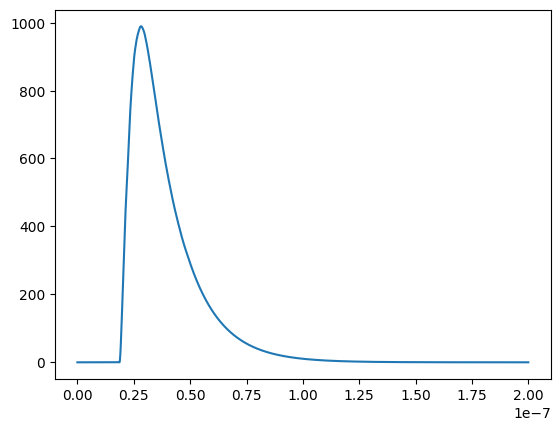

In [139]:
plot.plot(time_arr,waveform)

In [141]:

timing_oldCFD = processor.get_pulse_timing(waveform, threshold=pixel_threshold)
timing_newCFD = processorNEW.get_pulse_timing(waveform, threshold=pixel_threshold)
timing_constant = processor.constant_threshold_timing(waveform,threshold = pixel_threshold)

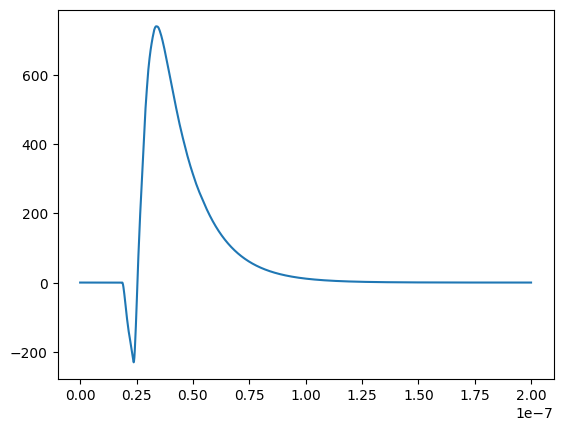

In [144]:
plot.plot(time_arr, timing_oldCFD[1])

In [73]:
model_compile = get_compiled_NF_model(thickness = "2cm")
inputProcessedData = "/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/processed_data/Feb_9_50events_run_0_3.json"
# inputProcessedData = "/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/processed_data/old_CFD_Feb_10_50events_run_3_4.json"
processed_data = load_defaultdict(inputProcessedData)

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/normflows/core.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


In [74]:
prepared_df = newer_prepare_nn_input(processed_data,model_compile,batch_size = 50000)

Processing data in new_prepare_nn_input...


100%|██████████| 49/49 [00:03<00:00, 16.11it/s]


Sampling data...


100%|██████████| 109/109 [01:13<00:00,  1.48it/s]


sampling took 73.72666501998901 seconds
Processing signal...


In [75]:
class HitDataset(DGLDataset):
    def __init__(self, data, filter_events,connection_mode = "kNN",max_distance = 0.5,k = 6):
        self.data = data
        self.filter_events = filter_events
        self.max_distance = max_distance
        self.event_data = torch.tensor([])
        self.connection_mode = connection_mode
        self.k = k
        self.dfs = []
        self.mass_dict = {130 : 0.497611}
        super().__init__(name = "KLM_reco")
    def get_max_distance_edges(self,curr_event):
        x = curr_event['strip_x'].values
        y = curr_event['strip_y'].values

        # Create coordinate matrices
        x_diff = x[:, np.newaxis] - x[np.newaxis, :]  # Creates a matrix of all x differences
        y_diff = y[:, np.newaxis] - y[np.newaxis, :]  # Creates a matrix of all y differences

        # Compute distances in one go
        distances = np.sqrt(x_diff**2 + y_diff**2)

        # Create mask for valid edges (upper triangle only to avoid duplicates)
        upper_mask = (distances < self.max_distance) & (np.triu(np.ones_like(distances), k=1) > 0)

        # Get edge indices for upper triangle
        src_upper, dst_upper = np.where(upper_mask)

        # Create the bidirectional edges
        sources = np.concatenate([src_upper, dst_upper])
        destinations = np.concatenate([dst_upper, src_upper])
        return sources,destinations
    def get_knn_edges(self,curr_event):
        """ 
        Given x and y coordinates of nodes, compute edges for a k-NN graph.

        Args:
            x (numpy array): x-coordinates of nodes.
            y (numpy array): y-coordinates of nodes.
            k (int): Number of nearest neighbors.

        Returns:
            sources (numpy array): List of source nodes.
            destinations (numpy array): List of destination nodes.
        """
        x = curr_event['strip_x'].values
        y = curr_event['strip_y'].values
        n = len(x)

        # The first notation with "np.newaxis" is the same as tensor.unsqueeze(-1)
        # It puts each value in its own dimension, like
        # x = np.arrayy([[a],[b],[c]]), so size is (N,1) rather than (N)
        # The second notation (x[np.newaxis,:]) just puts the array in another array so that the size is (1,N
        # rather than (N)
        x_diff = x[:, np.newaxis] - x[np.newaxis, :]
        y_diff = y[:, np.newaxis] - y[np.newaxis, :]
        
        # distances has shape (N,N) - matrix where the diagonal is 0, each entry is the distance between
        # the ith (column idx) node and the jth (row idx) node
        distances = np.sqrt(x_diff**2 + y_diff**2)

        # Get the indices of the k nearest neighbors for each node (excluding self-connections)
        # argsort sorts each row by the distance and returns the sorted indices
        # We use the [:,1:k+1] to take the first k indices besides the lowest (which is the diagonal self connection)
        knn_indices = np.argsort(distances, axis=1)[:, 1:self.k+1]

        # Create source and destination lists
        sources = np.concatenate([np.repeat(np.arange(n), self.k),knn_indices.flatten()])
        destinations = np.concatenate([knn_indices.flatten(),np.repeat(np.arange(n), self.k)])

        return sources, destinations
        
    def process(self):
        events_group = self.data.groupby(["event_idx","file_idx"])
        self.labels = torch.tensor([])
        self.graphs = []
        it_idx = 0
        for event_idx in events_group.groups:
            curr_event = events_group.get_group(event_idx)
            nhits = len(curr_event)
            '''FIRST FILTER FOR EVENTS'''
            if(self.filter_events):
                ModifiedTrueID_unique = np.array(curr_event['ModifiedTrueID'].unique())
                valid_ModifiedTrueID_unique = ModifiedTrueID_unique[ModifiedTrueID_unique != -1]
                #skip events with multiple valid trueIDs
                if(len(valid_ModifiedTrueID_unique) > 1):
                    continue
            
                #skip events with no valid ModififiedTrueIDs
                if(len(valid_ModifiedTrueID_unique) == 0):
                    continue
                # Remove rows that are hits outside of the cone
                curr_event = curr_event[curr_event.ModifiedTrueID != -1]
                nhits = len(curr_event)
            # Skip graphs with only 1 hit (or 0)
            if(nhits <2):
                continue;
            elif(nhits <self.k):
                sources = np.concatenate([np.repeat(np.arange(nhits),nhits),np.tile(np.arange(nhits),nhits)])
                destinations = np.concatenate([np.tile(np.arange(nhits),nhits),np.repeat(np.arange(nhits),nhits)])
            else:
                if(self.connection_mode == "max distance"):
                    sources, destinations = self.get_max_distance_edges(curr_event)
                elif(self.connection_mode == "kNN"):
                    sources, destinations = self.get_knn_edges(curr_event)
            g = dgl.graph((sources, destinations), num_nodes=nhits)
            #Want to predict energy
            try:
                mass = self.mass_dict[curr_event["truePID"].to_numpy()[0]]
            except Exception as e:
                truePID = curr_event["truePID"].to_numpy()[0]
                print(f"Exception: {e}")
                print(f"Particle with truePID of {truePID} not in dictionary. Skipping...")
                continue
            momentum = curr_event["P"].to_numpy()[0]
            energy = np.sqrt(mass**2 + momentum**2)
            label = torch.tensor(energy)
            '''VERSION LABEL INCLUDING EVENT FEATURES'''
            # Since this is the version with both SiPM in one hit/node, we have 2 times and charges
            # I hope that doing this will avoid making the NN learn that two hits at the same position are 
            # closely related
            feats = np.stack((
                curr_event["strip_x"].to_numpy() / 300,curr_event["strip_y"].to_numpy() / 300,
                curr_event["Time0"].to_numpy() / 5,
                curr_event["Charge0"].to_numpy(),
                curr_event["Time1"].to_numpy() / 5,
                curr_event["Charge1"].to_numpy()
#                 curr_event["stave_idx"].to_numpy(),
#                 curr_event["layer_idx"].to_numpy(),
#                 curr_event["segment_idx"].to_numpy()
            ),axis = -1)
            g.ndata["feat"] = torch.tensor(feats)#.unsqueeze(-1)
            self.dfs.append(curr_event)
            # Sort hits by time

            # Basic features
            total_charge = curr_event['Charge1'].sum() + curr_event['Charge0'].sum()
            max_charge = max([curr_event['Charge1'].max(),curr_event['Charge0'].max()])
            n_hits = len(curr_event)

            # Spatial features
#             hit_coords = curr_event[['strip_x', 'strip_y']].values

            # Center of gravity
#             cog_x = np.average(hit_coords[:, 0], weights=curr_event['Charge0'] + curr_event['Charge1'])
#             cog_y = np.average(hit_coords[:, 1], weights=curr_event['Charge0'] + curr_event['Charge1'])

            # Feature vector for this event
            event_features = torch.from_numpy(np.stack((label,
                total_charge,
                max_charge,
                n_hits,
#                 cog_x,
#                 cog_y,

                ),axis = -1))
            if(self.labels.shape[0] == 0):
                self.labels = event_features
            else:
                self.labels = torch.vstack((self.labels,event_features))
            #add graph to dataset
            self.graphs.append(g)
            it_idx += 1
        self.dim_nfeats = self.graphs[0].ndata["feat"].shape[1]
        self.dim_event_feats = self.labels.shape[1] - 1
        self.labels = self.labels.clone().detach().float()

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

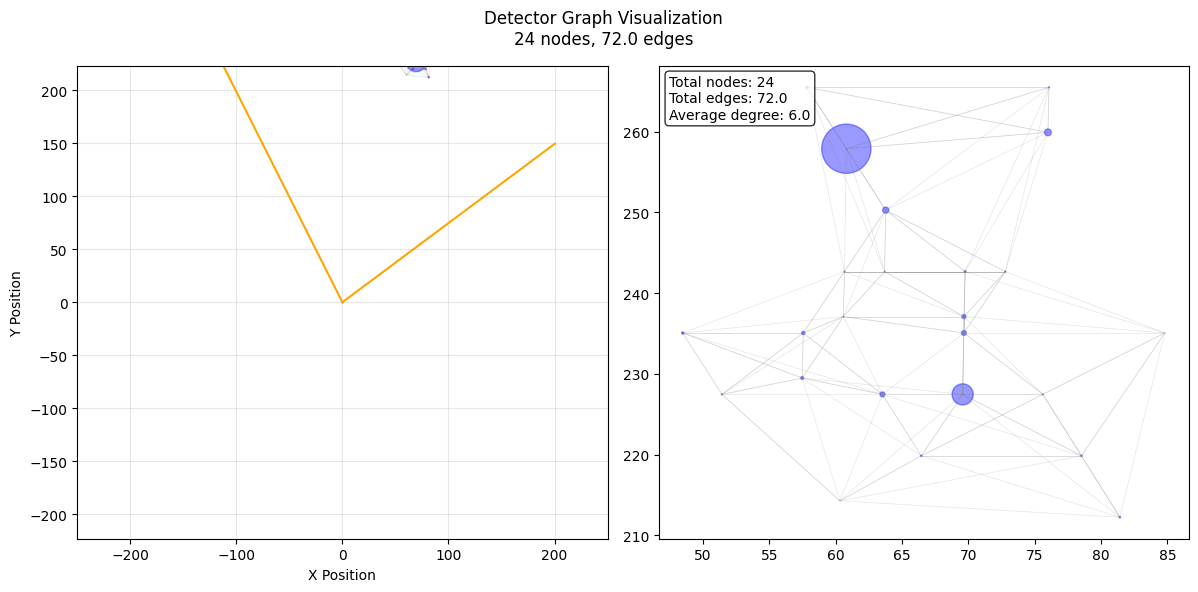

In [76]:

prepared_df["file_idx"] = 0
modified_df = process_df_vectorized(prepared_df, cone_angle_deg = 40)
dataset = HitDataset(modified_df,True,connection_mode = "kNN",k = 6)
visualize_detector_graph(dataset,graph_idx = 0)